In [155]:
import numpy as np
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

h, w = 28, 28

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def dsigmoid(x):
    return np.exp(x)/(1 + np.exp(x))

## Structure
### Input layer
Each pixel in the image corresponds to a input node (i.e. for 28x28 image there a total of 784 input nodes).

### Output layer
Each output node will correspond to the digits (0-9). The node with the maximum value will be taken as the answer.

### Hidden layer
The most important so far. There can be an arbitrary number of hidden layers depending upon the required complexity. Here we will use 2.

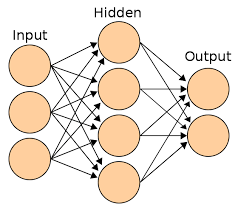

---

## How are we going to do it?
Each node is connected with each node in the layer before it, each one of these connections contains a weight and bias associated with it. Each node results in one singular floating point value which is calculated by $\sigma(\sum_{i=1}^{n} n_iw_i + b)$. Where $n$ is the total number of nodes in the previous layer, $n_i$ is the node in the previous layer, $w_i$ is the weight corresponding to it, $b$ is the bias and, $\sigma(x) = \frac{1}{1+e^{-x}}$ is the sigmoid function (used to normalize the values between 0 and 1). However the calculation is quite tedious. So we can simplify the contents of an entire layer using just a single matrix, and the output of a single layer as a single vector. Then we can simplity the entire process of calculating the value of each node into a just a few vector matrix multiplication and addition.

$$
\left[\begin{array}{cc} 
w_{1,1} & w_{1,2} & w_{1,3} & w_{1,4}\\
w_{2,1} & w_{2,2} & w_{2,3} & w_{2,4}\\
w_{3,1} & w_{3,2} & w_{3,3} & w_{3,4}\\
w_{4,1} & w_{4,2} & w_{4,3} & w_{4,4}\\
w_{5,1} & w_{5,2} & w_{5,3} & w_{5,4}\\
w_{6,1} & w_{6,2} & w_{6,3} & w_{6,4}\\
\end{array}\right]
\left[\begin{array}{cc} 
n_1\\ 
n_2\\
n_3\\
n_4
\end{array}\right]
+
\left[\begin{array}{cc} 
b_1\\ 
b_2\\
b_3\\
b_4\\
b_5\\
b_6
\end{array}\right]
=
\left[\begin{array}{cc} 
\sum_{i=1}^{4} n_iw_{1,i} + b_1\\ 
\sum_{i=1}^{4} n_iw_{2,i} + b_2\\
\sum_{i=1}^{4} n_iw_{3,i} + b_3\\
\sum_{i=1}^{4} n_iw_{4,i} + b_4\\
\sum_{i=1}^{4} n_iw_{5,i} + b_5\\
\sum_{i=1}^{4} n_iw_{6,i} + b_6
\end{array}\right]
$$

In [156]:
class Layer:
    # n is the number of nodes in the current layer and np is the number of nodes in the previous layer
    def __init__(self, n, n_p):
        self.weights = np.random.randn(n, n_p)
        self.biases = np.random.randn(n, 1)

    def __call__(self, l_p):
        return np.add(np.matmul(self.weights, l_p), self.biases)

In [157]:
input_layer_nodes = 3
hidden_layer_nodes = [6, 6]
output_layer_nodes = 2
layers = []
n_p = input_layer_nodes
for n in hidden_layer_nodes:
    layers.append(Layer(n, n_p))
    n_p = n
layers.append(Layer(output_layer_nodes, n_p))

result = sigmoid(np.random.randn(3, 1))
for i in range(0, len(layers)):
    result = sigmoid(layers[i](result))
result

array([[0.72152318],
       [0.06083665]])

## Now the hard part.
Actually making the neural network improve. But first we need to find the cost of our neural network i.e the deviation from the expected value. The cost function takes all the weights and biases and input and gives 1 number as the output which is the **cost** of the neural network.

$$
C(w_1, w_2, w_3, ..., w_k, b_1, b_2, ..., b_l) = \sum_{i=0}^{n} (n_i - e_i)^2
$$

where $n$ is the number of output nodes, $n_i$ is the value of the output node and $e_i$ is the expected value of the output node.

In [158]:
expected = np.array([1,0]).transpose()
difference = np.subtract(expected, result)
cost = (difference * difference).sum()
cost

1.4838739390910543

## What to do?
Our goal is to minimize the value of this cost function. By a method called **back-propagation**. This involves finding the negative gradient of the $C(...)$ function or the $-\Delta C(...)$ which will be a vector where each component will tell us the required magnitude by which we should increase or decrease a particular weight or bias to minimize the $C(...)$ function.

## How to find $-\Delta C(...)$?
The output node's result $a^{(L)}$ is given by the following expression.
$$a^{(L)} = \sigma(z^{(L)})$$
and $z^{(L)}$ is given by
$$z^{(L)} = \sum_{i=0}^{n^(L-1)}w^{(L)}_ia^{(L-1)}_i + b^{(L)}$$
Now we can use the chain rule to find the partial derivitive of $C(...)$ with respect to a given weight.
$$
\frac{\partial C}{\partial w_i^{(L)}} = \frac{\partial z^{(L)}}{\partial w^{(L)}_i}\frac{\partial a^{(L)}}{\partial z^{(L)}}\frac{\partial C}{\partial a^{(L)}}\\
\Rightarrow \frac{\partial C}{\partial w_i^{(L)}} = a^{(L-1)}_i\sigma'(z^{L})2(a^{(L)} - e^{(L)})
$$
where $e^{(L)}$ is the expected value for the particular node.

The bias is even simpler.
$$
\frac{\partial C}{\partial b^{(L)}} = \frac{\partial z^{(L)}}{\partial b^{(L)}}\frac{\partial a^{(L)}}{\partial z^{(L)}}\frac{\partial C}{\partial a^{(L)}}\\
\Rightarrow \frac{\partial C}{\partial b^{(L)}} = \sigma'(z^{L})2(a^{(L)} - e^{(L)})
$$

Now the partial derivitive of $C(...)$ with respect to $a^{(L - 1)}$ will be.
$$
\frac{\partial C}{\partial a^{(L-1)}_i} = \frac{\partial z^{(L)}}{\partial a^{(L-1)}}\frac{\partial a^{(L)}}{\partial z^{(L)}}\frac{\partial C}{\partial a^{(L)}}\\
\Rightarrow \frac{\partial C}{\partial a^{(L-1)}_i} = w^{(L)}_i\sigma'(z^{L})2(a^{(L)} - e^{(L)})
$$

## Back-propagation
How about finding the partial derivitive of a weight that is in the 2nd to last layer? Well we can use the chain rule again.
$$
\frac{\partial C}{\partial w_i^{(L-1)}} = \frac{\partial z^{(L-1)}}{\partial w^{(L-1)}_i}\frac{\partial a^{(L-1)}}{\partial z^{(L-1)}}\frac{\partial C}{\partial a^{(L-1)}}\\
\Rightarrow \frac{\partial C}{\partial w_i^{(L-1)}} = a^{(L-2)}_i\sigma'(z^{L})\frac{\partial C}{\partial a^{(L-1)}}
$$
similarly for the bias
$$
\frac{\partial C}{\partial b^{(L-1)}} = \frac{\partial z^{(L-1)}}{\partial b^{(L-1)}}\frac{\partial a^{(L-1)}}{\partial z^{(L-1)}}\frac{\partial C}{\partial a^{(L-1)}}\\
\Rightarrow \frac{\partial C}{\partial b^{(L-1)}} = \sigma'(z^{L})\frac{\partial C}{\partial a^{(L-1)}}
$$
$\frac{\partial C}{\partial a^{(L-1)}}$ can be calculated from the next node. This process will continue till we reach the input layer. This is known as back propagation.

## Using matrices
For simplification we have been using matrices and so we are going to use that for working together with each individual layer instead of each node.

### Calculating the weights in the output layer
First we take the results in the 2nd to last layer and then tile them horijontally according to the number 
$$
\left[\begin{array}{cc} 
a_1\\ 
a_2\\
a_3\\
a_4
\end{array}\right]
$$
Then we create a row matrix with each element equal to $\frac{\partial C}{\partial z^{(L)}_i}$.
$$
\frac{\partial C}{\partial z^{(L)}}=\left[\begin{array}{cc} 
\frac{\partial C}{\partial z^{(L)}_1} & \frac{\partial C}{\partial z^{(L)}_2} & \frac{\partial C}{\partial z^{(L)}_3} & \frac{\partial C}{\partial z^{(L)}_4} & \frac{\partial C}{\partial z^{(L)}_5} & \frac{\partial C}{\partial z^{(L)}_6}
\end{array}\right]
$$
Then the transpose of their product will be the required changes in the weights.
$$
\frac{\partial C}{\partial w^{(L)}} =
\left( 
\left[\begin{array}{cc} 
a_1\\ 
a_2\\
a_3\\
a_4
\end{array}\right]
\left(\frac{\partial C}{\partial z^{(L)}}\right)^T
\right)^T
$$

### Moving on to the next layer.
$$
\frac{\partial C}{\partial z^{(L-1)}} = \left(
\left(w^{(L)}\right)^T
\frac{\partial C}{\partial z^{(L)}}
\right)*\left[\begin{array}{cc} 
\frac{\partial a^{(L-1)}_1}{\partial z^{(L-1)}_1}\\
\frac{\partial a^{(L-1)}_2}{\partial z^{(L-1)}_2}\\
\frac{\partial a^{(L-1)}_3}{\partial z^{(L-1)}_3}\\
\frac{\partial a^{(L-1)}_4}{\partial z^{(L-1)}_4}\\
\frac{\partial a^{(L-1)}_5}{\partial z^{(L-1)}_5}\\
\frac{\partial a^{(L-1)}_6}{\partial z^{(L-1)}_6}
\end{array}\right]\\
\Rightarrow \frac{\partial C}{\partial z^{(L-1)}} = 
\left(
\left(w^{(L)}\right)^T
\frac{\partial C}{\partial z^{(L)}}
\right)
*
\left[\begin{array}{cc} 
\sigma'(z^{(L-1)}_1)\\
\sigma'(z^{(L-1)}_2)\\
\sigma'(z^{(L-1)}_3)\\
\sigma'(z^{(L-1)}_4)\\
\sigma'(z^{(L-1)}_5)\\
\sigma'(z^{(L-1)}_6)
\end{array}\right]
$$
Now the weights can be calculated using the above formula. Bias is the same as $\frac{\partial C}{\partial z^{(L)}}$.
$$\frac{\partial C}{\partial b^{(L)}} = \frac{\partial C}{\partial z^{(L)}}$$

In [159]:
input_layer_nodes = 3
hidden_layer_nodes = [6, 6]
output_layer_nodes = 2
layers = []
n_p = input_layer_nodes
for n in hidden_layer_nodes:
    layers.append(Layer(n, n_p))
    n_p = n
layers.append(Layer(output_layer_nodes, n_p))

input_data = np.random.randn(3, 1)
results = []
result = (input_data, sigmoid(input_data))
for i in range(0, len(layers)):
    result = layers[i](result[1])
    result = (result, sigmoid(result))
    results.append(result)
results

[(array([[-0.34552723],
         [ 1.12195271],
         [ 0.46074974],
         [ 0.84867875],
         [ 0.37810147],
         [-1.44097349]]),
  array([[0.41446747],
         [0.75435074],
         [0.61319202],
         [0.70028991],
         [0.59341512],
         [0.19139464]])),
 (array([[ 2.33901043],
         [ 2.59620954],
         [-0.21935143],
         [-1.09668743],
         [ 0.70017799],
         [-0.78693923]]),
  array([[0.91205674],
         [0.93061723],
         [0.44538097],
         [0.25036108],
         [0.66822723],
         [0.31282625]])),
 (array([[-2.16947495],
         [ 2.66326927]]),
  array([[0.10252533],
         [0.93482414]]))]

Now we are storing the results of each individual layer as well as the value without the sigmoid function applied.

In [160]:
expected = np.array([[1,0]]).transpose()
ngc = []
(z, a) = results[len(results) - 1]
q = dsigmoid(z) * np.subtract(a, expected)
ngc.append((np.matmul(a, q.transpose()), q))
q = np.matmul(layers[len(layers) - 1].weights.transpose(), q)
for i in range(len(layers) - 2, -1, -1):
    (z, _) = results[i]
    (_, a) = results[i - 1]
    q *= dsigmoid(z)
    ngc.append((np.matmul(a, q.transpose()), q))
    q = np.matmul(layers[i].weights.transpose(), q)
ngc

[(array([[-0.00943375,  0.0895965 ],
         [-0.08601681,  0.81693924]]),
  array([[-0.09201389],
         [ 0.87389617]])),
 (array([[ 0.79230972, -0.15914099,  0.07602403,  0.06986249,  0.27862471,
           0.07886537],
         [ 1.44204181, -0.28964425,  0.1383674 ,  0.1271531 ,  0.50711038,
           0.14353877],
         [ 1.17219813, -0.23544425,  0.11247524,  0.10335943,  0.41221679,
           0.11667891],
         [ 1.33869732, -0.26888679,  0.12845124,  0.11804062,  0.47076812,
           0.13325201],
         [ 1.13439195, -0.22785061,  0.10884765,  0.10002585,  0.39892181,
           0.11291574],
         [ 0.36587632, -0.07348884,  0.03510672,  0.03226141,  0.12866457,
           0.0364188 ]]),
  array([[ 1.91163304],
         [-0.38396496],
         [ 0.18342581],
         [ 0.16855965],
         [ 0.67224747],
         [ 0.1902812 ]])),
 (array([[0.08103281, 0.07605038, 0.01742722, 0.08725859, 0.09885242,
          0.01959582],
         [0.73885572, 0.69342602, 0.1

## Creating the final algorithm
Now all that's left is to take the average of the $-\Delta C(...)$ across all the training data and adding them to the matrices in the neural network. Usually the $-\Delta C(...)$ is multiplied by a contant $k$, which makes the neural network more prone to changes by new training data but also makes it more likely to deviate from the local minima.

In [180]:
class NeuralNetwork:
    def __init__(self, *layers):
        self.layers = []
        n_p = layers[0]
        for i in range(1, len(layers)):
            n = layers[i]
            self.layers.append(Layer(n, n_p))
            n_p = n
            
    def result(self, input_data):
        result = sigmoid(input_data)
        for layer in self.layers:
            result = sigmoid(layer(result))
        return result

    def _results(self, input_data):
        results = []
        result = (input_data, sigmoid(input_data))
        results.append(result)
        for i in range(0, len(self.layers)):
            result = self.layers[i](result[1])
            result = (result, sigmoid(result))
            results.append(result)
        return results

    def train(self, train_data, train_labels):
        ngc = []

        for layer in self.layers:
            ngc.append([np.zeros(layer.weights.shape), np.zeros(layer.biases.shape)])

        for j in range(len(train_data)):
            results = self._results(train_data[j])
            (z, a) = results[len(results) - 1]
            (_, a2) = results[len(results) - 2]
            q = dsigmoid(z) * np.subtract(a, train_labels[j])
            last_ngc = ngc[len(ngc) - 1]
            last_ngc[0] += np.matmul(a2, q.transpose()).transpose()
            last_ngc[1] += q
            q = np.matmul(self.layers[len(self.layers) - 1].weights.transpose(), q)
            for i in range(len(results) - 2, 0, -1):
                (z, _) = results[i]
                (_, a) = results[i - 1]
                q *= dsigmoid(z)
                current_ngc = ngc[i - 1]
                current_ngc[0] += np.matmul(a, q.transpose()).transpose()
                current_ngc[1] += q
                q = np.matmul(self.layers[i - 1].weights.transpose(), q)

        for i in range(len(layers)):
            layer = self.layers[i]
            current_ngc = ngc[i]
            layer.weights += current_ngc[0]
            layer.biases +=  current_ngc[1]

## Training
Let's train our neural network on a 100 data sets.

In [182]:
neural_network = NeuralNetwork(w*h, 1000, 1000, 10)
training_labels = []
training_data = []
for i in range(1000):
    label = np.zeros((10, 1))
    label[train_labels[i]][0] = 1
    training_labels.append(label)
    training_data.append(np.reshape(train_images[i], (h*w, 1)))
neural_network.train(np.array(training_data), np.array(training_labels))

testing_labels = []
for i in range(1):
    label = np.zeros((10, 1))
    label[test_labels[i]][0] = 1
    testing_labels.append(label)
print(testing_labels[0])
neural_network.result(test_images[0].reshape(h*w, 1))

/tmp/ipykernel_598/2371750339.py:13: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

A accuracy of the above neural network is quite bad. This can be improved by using a larger data set. But 1000 is already more that what jupyter notebook can comfortably handle. So let's leave it at that for now :)